# An Introduction to SageMaker Random Cut Forests

***Unsupervised anomaly detection on timeseries data a Random Cut Forest algorithm.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset which records the amount New York City taxi ridership over the course of six months. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

The following are ***not*** goals of this notebook:

* deeply understand the RCF model,
* understand how the Amazon SageMaker RCF algorithm works.

If you would like to know more please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Setup

***

*This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

## Select Amazon S3 Bucket

We first need to specify the locations where the original data is stored and where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)
* `downloaded_data_bucket` - An S3 bucket where data is downloaded from this [link](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv) and stored.
* `downloaded_data_prefix` - The location in the bucket where the data is stored.

In [1]:
import boto3
import botocore
import sagemaker
import sys


bucket = (
    sagemaker.Session().default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-benchmarks"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"explainable-ai-stall"
downloaded_data_prefix = "SimulatedData"


def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://sagemaker-us-east-1-293556221747/sagemaker/rcf-benchmarks
Downloaded training data will be read from s3://explainable-ai-stall/SimulatedData


## Obtain and Inspect Example Data


Our data comes from the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset [[1](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv)]. We downloaded data from [here](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv) and stored in an S3 bucket. These data consists of the number of New York City taxi passengers over the course of six months aggregated into 30-minute buckets. We know, a priori, that there are anomalous events occurring during the NYC marathon, Thanksgiving, Christmas, New Year's day, and on the day of a snow storm.

> [1] https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv

In [3]:
%%time

import pandas as pd

data_filename = "Stall_Data.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
flight_data = pd.read_csv(data_filename, delimiter=",")

CPU times: user 49.5 ms, sys: 8.76 ms, total: 58.2 ms
Wall time: 128 ms


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [4]:
flight_data.head()

,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_airspeed,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag
0,0,0,20388,552,4,50,16,25,-6.343871,166,...,166.000000,166.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1
1,1,0,20388,552,4,50,16,25,-6.343871,166,...,160.863771,163.431885,0.0,-0.779907,-0.389954,0.0,-0.277806,-0.136720,-0.277806,1
2,2,0,20388,552,4,50,16,25,-6.343871,166,...,156.033498,160.965756,0.0,19.511710,6.243934,0.0,7.184069,2.223251,7.184069,1
3,3,0,20388,552,4,50,16,25,-6.343871,166,...,164.554638,161.862977,0.0,-35.402997,-4.167798,0.0,-12.424910,-1.475577,-12.424910,1
4,4,0,20388,552,4,50,16,25,-6.343871,166,...,164.707329,162.431847,0.0,49.736454,6.613052,0.0,17.577179,2.333487,17.577179,1


Human beings are visual creatures so let's take a look at a plot of the data.

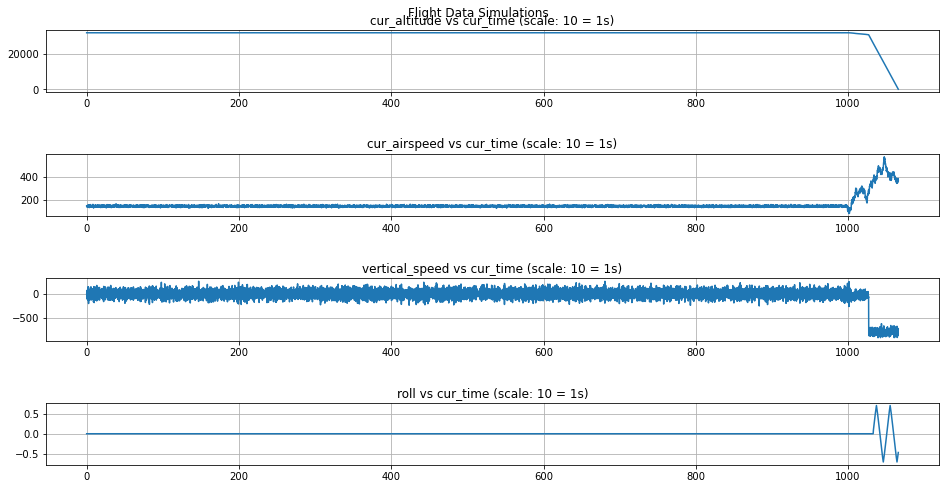

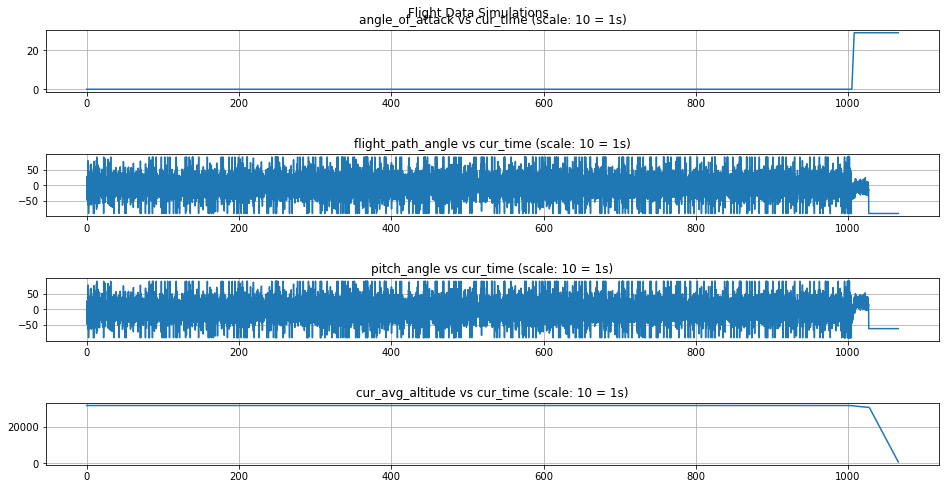

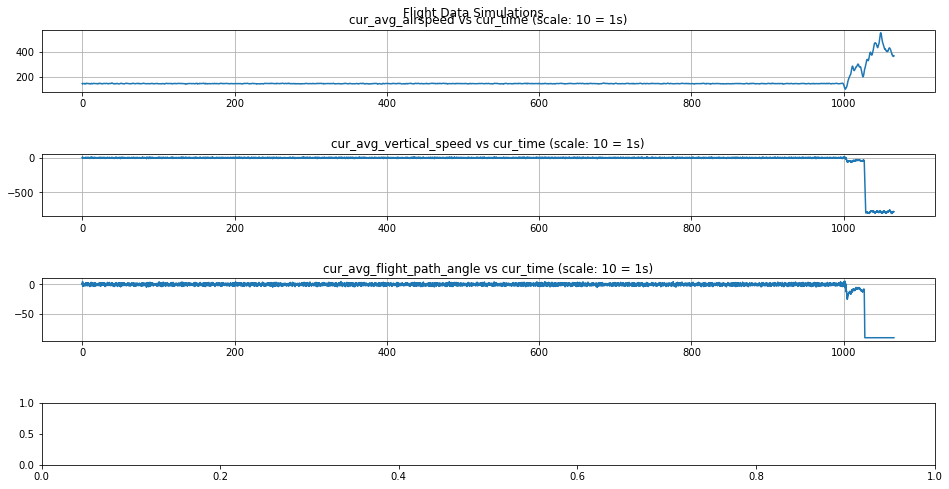

In [9]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt

# matplotlib.rcParams["figure.dpi"] = 100

# flight_data.plot("vertical_speed")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def lineplots_flight_data(cols, time, df, n):
    fig, axs = plt.subplots(nrows, 1, figsize=(16, 8))
    for col, ax in zip(cols, axs.flatten()):
        ax.grid()
        ax.plot(time, df[col])
        ax.set_title(col + ' vs ' + time.name + ' (scale: 10 = 1s)')
        #ax.set_xticks(np.arange(min(time), max(time) + 10, 10.0))
    plt.subplots_adjust(hspace=1, wspace=0.1)
    fig.suptitle('Flight Data Simulations', y=0.92)
#     fig.savefig(cwd + '/visuals/' + 'flight_data' + str(n) + '.png')
    plt.show()
    plt.close()


if __name__ == '__main__':
    df = flight_data
    cols = ['cur_altitude', 'cur_airspeed', 'vertical_speed', 'roll', 'angle_of_attack', 'flight_path_angle', 'pitch_angle',
            'cur_avg_altitude', 'cur_avg_airspeed', 'cur_avg_vertical_speed', 'cur_avg_flight_path_angle']
    time = df['cur_time']
    nrows = 4  # How many figures you want in a single plot
    # Using list comprehension (https://www.geeksforgeeks.org/break-list-chunks-size-n-python/) to break up cols list into chunks based on nrows
    split_cols = [cols[i * nrows:(i + 1) * nrows] for i in range((len(cols) + nrows - 1) // nrows)]
    for n in range(len(split_cols)):
        lineplots_flight_data(split_cols[n], time, df, n)

# Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the taxi cab data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [12]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(flight_data.to_numpy()))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-08 15:03:34 Starting - Starting the training job...
2021-07-08 15:03:58 Starting - Launching requested ML instancesProfilerReport-1625756614: InProgress
...
2021-07-08 15:04:32 Starting - Preparing the instances for training.........
2021-07-08 15:06:00 Downloading - Downloading input data...
2021-07-08 15:06:18 Training - Downloading the training image..
2021-07-08 15:07:00 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[07/08/2021 15:06:53 INFO 139861070788416] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}


In [13]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2021-07-08-15-03-34-385


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [14]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------------------!

In [15]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2021-07-08-15-08-32-980


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [16]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [17]:
flight_data_numpy = flight_data.to_numpy()
print(flight_data_numpy[:6])
results = rcf_inference.predict(
    flight_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[ 0.00000000e+00  0.00000000e+00  3.15990000e+04  9.99000000e+02
   4.00000000e+00  2.70000000e+01  3.40000000e+01  3.00000000e+00
  -4.94891000e+00  1.48000000e+02  2.80000000e+01  4.69000000e+02
   6.00000000e+00  2.90000000e+01  9.55949145e-01  0.00000000e+00
  -1.94406500e+00 -2.64032120e+01  1.76139200e+00 -1.03402660e+01
   3.15990000e+04  3.15990000e+04  1.48000000e+02  1.48000000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  3.15990000e+04  9.99000000e+02
   4.00000000e+00  2.70000000e+01  3.40000000e+01  3.00000000e+00
  -4.94891000e+00  1.48000000e+02  2.80000000e+01  4.69000000e+02
   6.00000000e+00  2.90000000e+01  9.55949145e-01  1.00000000e-01
   4.66801000e-01 -3.14329570e+01 -1.81435200e+00 -7.35947900e+00
   3.15994668e+04  3.15992334e+04  1.46185648e+02  1.47092824e+02
   0.00000000e+00  4.66801000e+00  2.33400500e+00  0.00000000e+00
   1.8300

## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the Vertical Speed in thedataset.

In [18]:
results = rcf_inference.predict(flight_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
flight_data["score"] = pd.Series(scores, index=flight_data.index)
flight_data.head()

,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag,score
0,0,0,31599,999,4,27,34,3,-4.94891,148,...,148.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,1,6.444997
1,1,0,31599,999,4,27,34,3,-4.94891,148,...,147.092824,0.0,4.66801,2.334005,0.0,1.830019,0.909250,1.830019,1,6.446442
2,2,0,31599,999,4,27,34,3,-4.94891,148,...,147.039185,0.0,14.25792,6.308643,0.0,5.569018,2.459183,5.569018,1,6.441012
3,3,0,31599,999,4,27,34,3,-4.94891,148,...,147.751279,0.0,-11.33209,1.898460,0.0,-4.336243,0.736269,-4.336243,1,6.448676
4,4,0,31599,999,4,27,34,3,-4.94891,148,...,146.261711,0.0,54.08289,12.335346,0.0,22.674646,4.838286,22.674646,1,6.452166


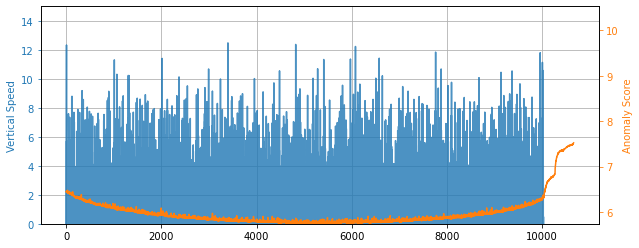

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(flight_data)
# start, end = 5500, 6500
flight_data_subset = flight_data[start:end]

ax1.plot(flight_data_subset["cur_avg_vertical_speed"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Vertical Speed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(0,15)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

In [27]:
score_mean = flight_data["score"].mean()
score_std = flight_data["score"].std()
score_cutoff = score_mean + 3 * score_std

anomalies = flight_data_subset[flight_data_subset["score"] > score_cutoff]
anomalies

,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag,score
10274,10274,0,31599,999,4,27,34,3,-4.94891,148,...,264.645371,0.000000,-802.75242,-226.381368,29.0,-90.00663,-58.809839,-61.00663,1,6.989829
10275,10275,0,31599,999,4,27,34,3,-4.94891,148,...,265.343595,0.000000,-861.23416,-267.985139,29.0,-90.00663,-90.006630,-61.00663,1,7.014313
10276,10276,0,31599,999,4,27,34,3,-4.94891,148,...,265.996686,0.000000,-799.24502,-306.718587,29.0,-90.00663,-90.006630,-61.00663,1,7.011855
10277,10277,0,31599,999,4,27,34,3,-4.94891,148,...,267.762066,0.000000,-773.22637,-341.501248,29.0,-90.00663,-90.006630,-61.00663,1,7.023217
10278,10278,0,31599,999,4,27,34,3,-4.94891,148,...,268.833070,0.000000,-836.28033,-381.953964,29.0,-90.00663,-90.006630,-61.00663,1,7.035756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10655,10655,0,31599,999,4,27,34,-31,-4.94891,148,...,364.611764,-0.529919,-860.43854,-778.097411,29.0,-90.00663,-90.006630,-61.00663,1,7.515785
10656,10656,0,31599,999,4,27,34,-30,-4.94891,148,...,365.243848,-0.515038,-798.24171,-779.627645,29.0,-90.00663,-90.006630,-61.00663,1,7.517478
10657,10657,0,31599,999,4,27,34,-29,-4.94891,148,...,366.813377,-0.500000,-730.20381,-781.486475,29.0,-90.00663,-90.006630,-61.00663,1,7.518999
10658,10658,0,31599,999,4,27,34,-28,-4.94891,148,...,368.415786,-0.484810,-756.84723,-782.519408,29.0,-90.00663,-90.006630,-61.00663,1,7.520571


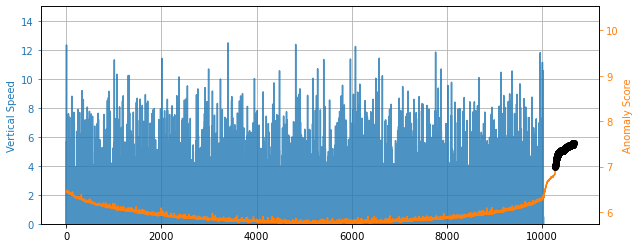

In [28]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [ ]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

# Epilogue

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in a taxi ridership dataset. In these data the anomalies occurred when ridership was uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

Depending on the kind of data you have there are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If you know that a particular set of data is characteristic of "normal" behavior then training on said set of data will more accurately characterize "abnormal" data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with known period, such as the NYC taxi dataset used above. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [ ]:
import numpy as np


def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data


# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = "sagemaker/randomcutforest_shingled"
taxi_data_shingled = shingle(taxi_data.values[:, 1], shingle_size)
print(taxi_data_shingled)

We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

In [ ]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix_shingled}/",
    output_path=f"s3://{bucket}/{prefix_shingled}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data_shingled))

In [ ]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

In [ ]:
print(rcf_inference.content_type, rcf_inference.accept)

Using the above inference endpoint we compute the anomaly scores associated with the shingled data.

In [ ]:
# Score the shingled datapoints
results = rcf_inference.predict(
    taxi_data_shingled, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)
scores = np.array([datum["score"] for datum in results["scores"]])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3 * score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

Finally, we plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold.

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data["value"], color="C0", alpha=0.8)
ax2.plot(scores, color="C1")
ax2.scatter(anomaly_indices, anomalies, color="k")

ax1.grid(which="major", axis="both")
ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

We see that with this particular shingle size, hyperparameter selection, and anomaly cutoff threshold that the shingled approach more clearly captures the major anomalous events: the spike at around t=6000 and the dips at around t=9000 and t=10000. In general, the number of trees, sample size, and anomaly score cutoff are all parameters that a data scientist may need experiment with in order to achieve desired results. The use of a labeled test dataset allows the used to obtain common accuracy metrics for anomaly detection algorithms. For more information about Amazon SageMaker Random Cut Forest see the [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

In [ ]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)